# Import libraries and data


In [1]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62.6 MB 1.2 MB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6751290 sha256=3642ed7af786b32c7514ca29fca01c6c044cb4c828a96063037e801d8f3f5b37
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the 

In [2]:
#import libraries
import itertools #used to iterate over data structures that can be stepped over using a for-loop
from fbprophet import Prophet #provided completely automated forecasts
import pandas as pd #analyze data
import numpy as np #provided a large number of mathematical, algebraic, and transformation functions
import matplotlib.pyplot as plt #create 2D graphs and plots by using python scripts
import matplotlib.dates as mdates #plot data that consists of dates.

In [3]:
#get the data
data = pd.read_csv("/content/ETH-USD.csv")
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-26,763.369995,786.789978,760.934998,773.835999,773.835999,2201159936
1,2017-12-27,774.969971,789.252991,738.413025,762.841980,762.841980,2100029952
2,2017-12-28,762.208008,763.318970,701.187012,737.023010,737.023010,2389149952
3,2017-12-29,740.388977,770.117004,729.607971,753.591980,753.591980,2648969984
4,2017-12-30,753.815002,753.815002,685.231018,717.257019,717.257019,3187780096


In [4]:
#select 2 variables: Date and Close
dataset = data.loc[:, ["Date","Close"]] #label indexing
dataset.head(5) #display the number of rows of our choice                       

,Date,Close
0,2017-12-26,773.835999
1,2017-12-27,762.841980
2,2017-12-28,737.023010
3,2017-12-29,753.591980
4,2017-12-30,717.257019


#Data Transformation

After reading the input file, proceed to edit the data type and rename the column because Prophet is built with two main features:
+ ds: has date format, timestamps
+ y: represents the quantitative value, representing the measurement that we predict

In [5]:
#Date variable, return datetime format in python
dataset.Date = pd.to_datetime(dataset.Date,
                                format = "%Y-%m-%d")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1827 non-null   datetime64[ns]
 1   Close   1827 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


In [6]:
#renaming variable
dataset = dataset.rename(columns = {'Close' : 'y'})
dataset = dataset.rename(columns = {'Date' : 'ds'})
dataset.head(5)

,ds,y
0,2017-12-26,773.835999
1,2017-12-27,762.841980
2,2017-12-28,737.023010
3,2017-12-29,753.591980
4,2017-12-30,717.257019


#Training and Test Set

Next, the data will be split, then it can be split according to the ratio of 90% train and 10% test or choose a certain length as the test data set length.

Here, we use the last 31 lines to test the prediction results and the remaining lines to build the model.

In [50]:
#Training and test set
test_days = int(len(dataset)*0.1) #take 10% length of test data 
training_set = dataset.iloc[:-test_days, :] #training_set: subset to train the model
test_set = dataset.iloc[-test_days:, :] #test_set: subset to test the model
test_set.tail(5)

,ds,y
1822,2022-12-22,1218.182129
1823,2022-12-23,1220.159424
1824,2022-12-24,1221.148560
1825,2022-12-25,1218.962036
1826,2022-12-26,1219.282593


In [53]:
len(training_set)

1645

In [54]:
len(test_set)

182

#Facebook Prophet

First, build the Prophet model.

In this model there are many parameters such as:

*   growth: trend of the pattern

*   changepoint_num: maximum number of trend change points

*   changepoint_range: range affects the distance between change points to the time series. 

**Note:** The larger the value, the more flexible the trend is.

*   Seasonality by year, week, and day: seasonality_yearly, seasonality_weekly, seasonality_daily.

*   seasonality_mode: seasonality.

*   changepoint_prior_scale: adjust the strength of the trend. The default 

*   changepoint_prior_scale is 0.05. When changepoint_prior_scale goes down, the trend is less active and conversely, when changepoint_prior_scale is increased, the trend is more flexible.



In [55]:
#Facebook Prophet model
m = Prophet(growth = "linear",
            yearly_seasonality = True, #True or False if there is or there isn’t yearly seasonality.
            weekly_seasonality = True, #True or False if there is or there isn’t weekly seasonality. 
            daily_seasonality = False, #True or False if there is or there isn’t daily seasonality. 
            seasonality_mode = "multiplicative", #the effect of the seasonality is added to the trend to get the forecast.
            seasonality_prior_scale = 10, #strength of the seasonality component or components. This value can be general for all the seasonalities or adjusted specifically for each of them.
            holidays_prior_scale = 10, #strength of the holiday component.
            changepoint_prior_scale = 0.05) #the strength or possibility of trend change. The bigger the value, the higher the flexibility of the trend.
m.fit(training_set)

#forecasting 

Because Prophet predicts values based on time series, it is necessary to create a dataframe containing the dates to be predicted in the future.
Here, there are two ways:

*   Use an existing test_set

*   In the absence of test_set, use the make_future_dataframe function.

Including some parameters:

*   m: model Prophet

*   periods: predicted period

*   freq: 'day', 'week', 'month', 'quarter', 'year', 1(1 sec), 60(1 minute) or 3600(1 hour).

*   include_history : Boolean data type, check dataset containing dataframe about historical dates

Through the make_futuer_dataframe function, Prophet helps generate the next days for prediction. In this code, we predict the next 31 days. And one important thing is that we need to determine the frequency of data we want. Suppose, for daily data <strong>fred='D'</strong> or monthly data <strong>fred='MS'</strong>. However, by default, Prophet provides prediction data by date.




In [62]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future 

,ds
0,2017-12-26
1,2017-12-27
2,2017-12-28
3,2017-12-29
4,2017-12-30
...,...
1822,2022-12-22
1823,2022-12-23
1824,2022-12-24
1825,2022-12-25


Match the newly created column ds with the actual value in the test dataset.

In [63]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,1:]],
                   axis = 1)
future.tail(5)

,ds,y
1822,2022-12-22,1218.182129
1823,2022-12-23,1220.159424
1824,2022-12-24,1221.148560
1825,2022-12-25,1218.962036
1826,2022-12-26,1219.282593


Make predictions for that set of values.

Prophet returns a new Dataframe with more diverse attribute columns. However, we need to consider three main properties in this prediction process:

* y_hat: forecast value over time
* y_hat_lower: lower limit of forecast value <strong>y_hat</strong>
* y_hat_upper: upper limit of forecast value <strong>y_hat</strong>

In [64]:
#forecast
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1822,2022-12-22,1488.131746,1251.810575,2443.081211,1069.143970,1915.540629,0.243493,0.243493,0.243493,-0.000174,-0.000174,-0.000174,0.243667,0.243667,0.243667,0.0,0.0,0.0,1850.480785
1823,2022-12-23,1483.756608,1259.066610,2409.195218,1061.045381,1914.336511,0.235677,0.235677,0.235677,-0.005634,-0.005634,-0.005634,0.241311,0.241311,0.241311,0.0,0.0,0.0,1833.444373
1824,2022-12-24,1479.381471,1241.834470,2426.954462,1054.532351,1913.287038,0.236667,0.236667,0.236667,-0.002387,-0.002387,-0.002387,0.239054,0.239054,0.239054,0.0,0.0,0.0,1829.502967
1825,2022-12-25,1475.006333,1211.887418,2419.083292,1048.019320,1911.662699,0.237941,0.237941,0.237941,0.001134,0.001134,0.001134,0.236807,0.236807,0.236807,0.0,0.0,0.0,1825.971500
1826,2022-12-26,1470.631195,1217.801920,2393.588915,1039.360010,1910.168005,0.233728,0.233728,0.233728,-0.000743,-0.000743,-0.000743,0.234471,0.234471,0.234471,0.0,0.0,0.0,1814.358816


Get predicted data.

In [65]:
#predictions
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

1645    1358.546145
1646    1358.251373
1647    1330.278637
1648    1306.445576
1649    1303.059231
Name: prophet, dtype: float64

#Visualization

<LI>Presentation of forecast components through plot_components: trend, yearly seasonality and weekly seasonality.

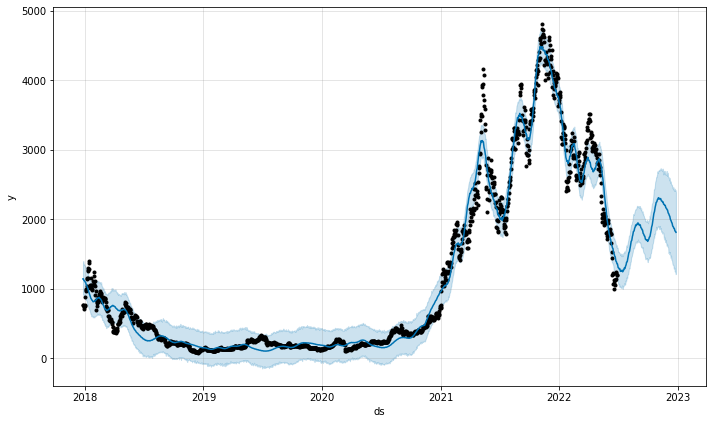

In [66]:
#visualization forecast
m.plot(forecast);

<LI>Presentation of forecast components through plot_components: trend, yearly seasonality and weekly seasonality.

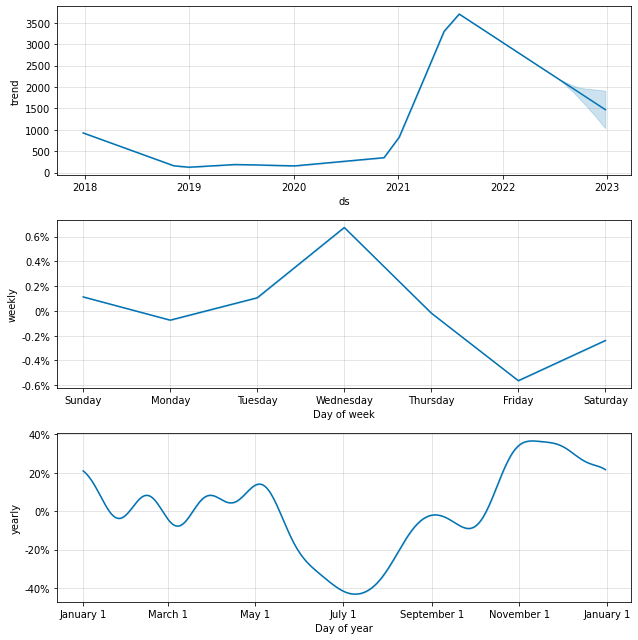

In [67]:
#plot components
m.plot_components(forecast);

#Model assessment

In [68]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))

488.0
574.0


In [69]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

36.80647541778189

# Cross-Validation

Prophet has a function to measure forecasting error in time series data. That process is done by selecting cutoff points in the data history and each of them is suitable for training the model using the data up to that cutoff point.

The initial period must be long enough to capture all the components inside the model, especially the seasonalities and extra regressors. In which, we consider at least one year for annual seasonality and weekly for weekly seasonality.

Here, we perform predictability assessment with 1-and-a-half year training data in the first cut and make the prediction again after 31 days.

In [70]:
#CV
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                         #Dự đoán 31 ngày tiếp theo
                         horizon = '31 days',
                         #Lấy 540 ngày dể đào tạo
                         initial = '540 days',
                         #Xử lý song song
                         parallel = "processes")
df_cv.head()

INFO:fbprophet:Making 70 forecasts with cutoffs between 2019-06-22 12:00:00 and 2022-05-27 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f002e49cbb0>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-23,241.673006,190.018902,294.732550,307.827789,2019-06-22 12:00:00
1,2019-06-24,236.301581,186.099894,286.891457,310.424683,2019-06-22 12:00:00
2,2019-06-25,235.860339,180.935085,285.152470,318.126312,2019-06-22 12:00:00
3,2019-06-26,232.725567,178.032886,287.231505,336.753174,2019-06-22 12:00:00
4,2019-06-27,231.687372,177.611383,283.598406,294.267639,2019-06-22 12:00:00


In [71]:
#MAE and RMSE
print(round(mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print(round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])), 0))
print(MAPE(df_cv['y'], df_cv['yhat']))

405.0
720.0
26.287404068227637


#Hyperparameter tuning

List the parameters and assign values and choose the model that gives the minimum evaluation criteria.

In [72]:
#Parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale': np.arange(5, 10, 5), #[5, 10]  np.arange(5, 20, 5),
              'changepoint_prior_scale': np.arange(0.01, 0.05, 0.01),  # [0.01, 0.02, 0.03, 0.04, 0.05]
              'holidays_prior_scale': np.arange(5, 10, 5)}#[5, 10]
grid = ParameterGrid(param_grid)
list(grid)[:3]            

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.02,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.03,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5}]

In [73]:
#Hyper parameter tuning
rmse = []
for params in grid:
  #build model
  m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale = params['changepoint_prior_scale'])
  m.fit(training_set)

  #cross-validation
  df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
  
  #gather the results
  error = np.sqrt(mean_squared_error(df_cv['y'], 
                                     df_cv['yhat']))
  rmse.append(error)

INFO:fbprophet:Making 70 forecasts with cutoffs between 2019-06-22 12:00:00 and 2022-05-27 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f003a680eb0>
INFO:fbprophet:Making 70 forecasts with cutoffs between 2019-06-22 12:00:00 and 2022-05-27 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f003a680eb0>
INFO:fbprophet:Making 70 forecasts with cutoffs between 2019-06-22 12:00:00 and 2022-05-27 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f002e5e51f0>
INFO:fbprophet:Making 70 forecasts with cutoffs between 2019-06-22 12:00:00 and 2022-05-27 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0030e5a8e0>


In [74]:
#best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 5, 'holidays_prior_scale': 5, 'changepoint_prior_scale': 0.04}


#Final Prophet Model

Rebuild models and predictions.

In [75]:
#build model
m = Prophet(growth = "linear",
          yearly_seasonality = True,
          weekly_seasonality = True,
          daily_seasonality = False,
          seasonality_mode = "multiplicative",
          seasonality_prior_scale = best_params['seasonality_prior_scale'],
          holidays_prior_scale = best_params['holidays_prior_scale'],
          changepoint_prior_scale = best_params['changepoint_prior_scale'])
m.fit(training_set)

In [76]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future = pd.concat([future, dataset.iloc[:,1:]],
                   axis = 1)
future.tail(1)

,ds,y
1826,2022-12-26,1219.282593


In [77]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-12-26,926.739655,912.334884,1377.317731,926.739655,926.739655,0.234471,0.234471,0.234471,0.001123,0.001123,0.001123,0.233348,0.233348,0.233348,0.0,0.0,0.0,1144.033498
1,2017-12-27,924.318014,911.515917,1374.684643,924.318014,924.318014,0.237452,0.237452,0.237452,0.006749,0.006749,0.006749,0.230704,0.230704,0.230704,0.0,0.0,0.0,1143.799625
2,2017-12-28,921.896373,895.854421,1379.128667,921.896373,921.896373,0.227550,0.227550,0.227550,-0.000179,-0.000179,-0.000179,0.227729,0.227729,0.227729,0.0,0.0,0.0,1131.673855
3,2017-12-29,919.474733,884.113837,1355.533486,919.474733,919.474733,0.218667,0.218667,0.218667,-0.005647,-0.005647,-0.005647,0.224314,0.224314,0.224314,0.0,0.0,0.0,1120.533716
4,2017-12-30,917.053092,872.476461,1344.381087,917.053092,917.053092,0.217946,0.217946,0.217946,-0.002406,-0.002406,-0.002406,0.220352,0.220352,0.220352,0.0,0.0,0.0,1116.921280


In [78]:
#MAE, RMSE and MAPE
print(round(mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print(round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])), 0))
print(MAPE(df_cv['y'], df_cv['yhat']))

412.0
735.0
26.65670708915696
